# Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from gensim.models import FastText 
from datasets import load_dataset

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Config

# Code

## data load

In [4]:
dataset = load_dataset("tesemnikov-av/toxic_dataset_ner")

/Users/ruasvmv/PycharmProjects/toxic_segmenter/venv/lib/python3.8/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Using custom data configuration tesemnikov-av--toxic_dataset_ner-8df972753495a603
Found cached dataset parquet (/Users/ruasvmv/.cache/huggingface/datasets/tesemnikov-av___parquet/tesemnikov-av--toxic_dataset_ner-8df972753495a603/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
x = dataset['train']['tokens']

In [6]:
y = dataset['train']['tags']

In [7]:
for i in x[:2]:
    print(' '.join(i))

Кого угодно, но не этих двух отбросов: свинью и недоразвитого дауна.
Мне давно уже не пишешь коменты типа " прекрасная и тд" а вот другим блять пишешь:( была какая то надежда теперь ее вообще не осталось\. \.


In [8]:
for i in y[:2]:
    print(i)

['O', 'O', 'O', 'O', 'O', 'O', 'TOXIC', 'TOXIC', 'O', 'O', 'TOXIC']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'TOXIC', 'O', 'O', 'TOXIC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [9]:
for xx, yy in tqdm(zip(x, y), total=len(x)):
    assert(len(xx) == len(yy))

100%|██████████████████████████████████████████████████████████████████████████| 45000/45000 [00:00<00:00, 1667965.85it/s]


## eda

In [10]:
x_lens = [len(item) for item in x]

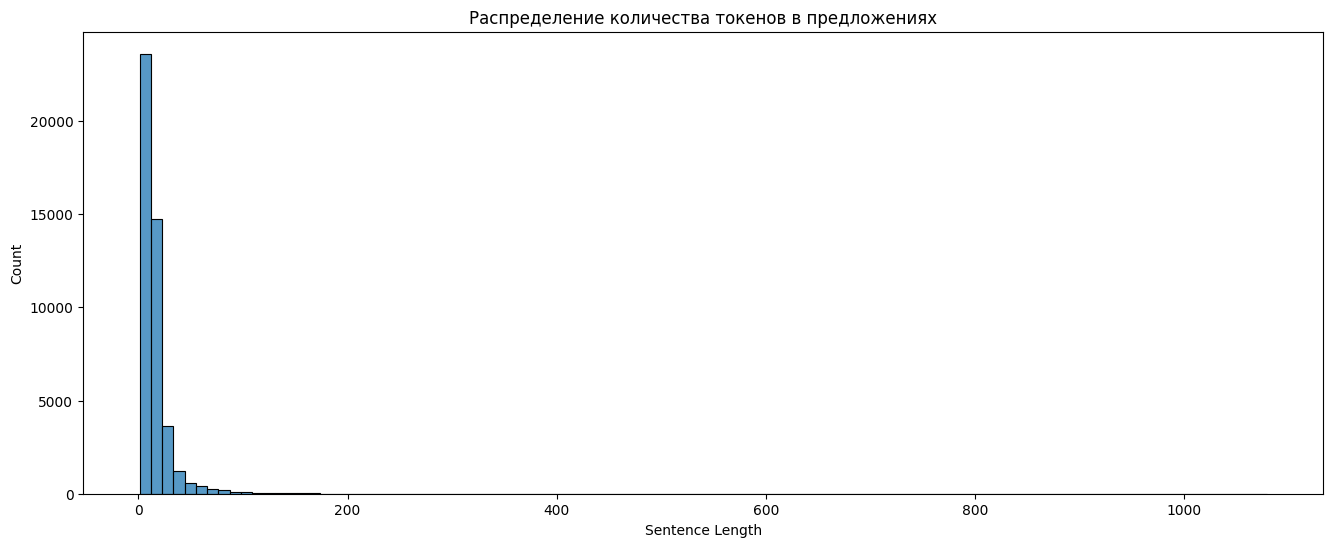

In [11]:
plt.figure(figsize=(16,6))
sns.histplot(x=x_lens, bins=100)
plt.title('Распределение количества токенов в предложениях')
plt.xlabel('Sentence Length')
plt.show()

In [12]:
target = []
for yy in y:
    target += list(map(lambda item: 1 if item == 'TOXIC' else 0, yy))

In [13]:
pd.value_counts(target) / len(target) * 100

0    90.712634
1     9.287366
dtype: float64

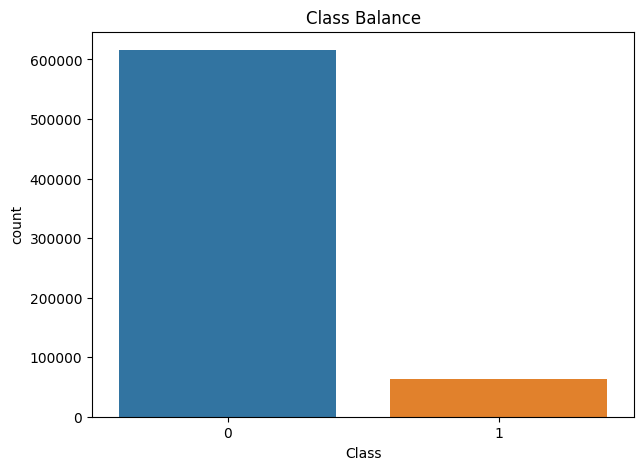

In [14]:
plt.figure(figsize=(7,5))
sns.countplot(x=np.array(target))
plt.xlabel('Class')
plt.title('Class Balance')
plt.show()

## fasttext test

In [15]:
%%time
vocabulary = FastText(x)

CPU times: user 18.4 s, sys: 349 ms, total: 18.7 s
Wall time: 8.31 s


In [16]:
vocabulary.wv.most_similar(positive='питух')

[('пил!', 0.9929501414299011),
 ('пиво', 0.9924869537353516),
 ('пидер', 0.9912881851196289),
 ('идиот.', 0.9910710453987122),
 ('пи', 0.9908976554870605),
 ('ебланы', 0.9903988838195801),
 ('пинка', 0.9902127385139465),
 ('идиот,', 0.9899083375930786),
 ('пил', 0.9898788928985596),
 ('идиота', 0.9896626472473145)]

## torch dataset

In [17]:
train_tags = list(map(lambda sentence: list(map(lambda item: 1 if item == 'TOXIC' else 0, sentence)), y))

In [18]:
%%time
train_features = list(map(lambda sentence: list(map(lambda item: vocabulary.wv[item], sentence)), x))

CPU times: user 7.33 s, sys: 130 ms, total: 7.46 s
Wall time: 7.47 s


In [19]:
class ToxicDataset(Dataset):
    def __init__(self, features: list, tags: list):
        self.features = features
        self.tags = tags
        
    def __getitem__(self, item) -> dict:
        return {
            'feature': self.features[item],
            'tag': self.tags[item]
        }
    
    def __len__(self) -> int:
        return len(self.tags)

In [20]:
train_dataset = ToxicDataset(features=train_features, tags=train_tags)

In [21]:
len(train_dataset)

45000

In [22]:
train_data, valid_data = random_split(train_dataset, [35_000, 10_000],
                                      generator=torch.Generator().manual_seed(42)
                                     )

In [23]:
def collate_fn(batch) -> dict:

    max_len = max(len(row['feature']) for row in batch)

    feature = torch.empty((len(batch), max_len, 100), dtype=torch.float32)
    tag = torch.empty((len(batch), max_len), dtype=torch.long)

    for idx, row in enumerate(batch):
        to_pad = max_len - len(row['feature'])
        _feat = np.array(row['feature'])
        _tag = row['tag']
        feature[idx] = torch.cat((torch.tensor(_feat), torch.zeros((to_pad, 100))), axis=0)
        tag[idx] = torch.cat((torch.tensor(_tag), torch.zeros(to_pad)))
    return {
        'feature': feature,
        'tag': tag,
    }

In [24]:
train_loader = DataLoader(train_data, batch_size=32, collate_fn=collate_fn, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, collate_fn=collate_fn, shuffle=False)

In [25]:
for batch in train_loader:
    feat, tag = batch['feature'], batch['tag']
    print(feat[0])
    break

tensor([[-0.7916,  0.6294,  0.2079,  ..., -0.8366, -0.3302, -0.3218],
        [-1.2476, -0.2281,  0.3157,  ..., -0.2107, -0.3345,  0.0671],
        [-1.7536,  0.0228, -0.1923,  ..., -1.5306, -0.5523,  0.7956],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


## model

In [26]:
class ToxicSegmenter(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        out_channels: int,
        output_dim: int,
        dropout=0.5,
    ):
        super().__init__()
                
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=out_channels,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        
        self.fc = nn.Linear(2 * out_channels, output_dim)
        
    def forward(self, text):        
        x, (_, _) = self.lstm(text)
#         print('lstm: ', x.shape)

        return self.fc(x)

In [27]:
model = ToxicSegmenter(embedding_dim=100, out_channels=256, output_dim=2)

In [28]:
for batch in train_loader:
    feat, tag = batch['feature'], batch['tag']
    print(model(feat).shape)
    break

torch.Size([32, 84, 2])


## fit

In [29]:
def train(model: nn.Module,
          training_data_loader: DataLoader,
          validating_data_loader: DataLoader,
          criterion: nn.Module,
          optimizer: torch.optim.Optimizer,
          device: str):
    train_loss = 0.0
    val_loss = 0.0

    model.train()
    for batch in tqdm(training_data_loader):
        text, label = batch['feature'], batch['tag']
        text = text.to(device)
        label = label.view(-1).to(device)

        y_predict = model(text)
        y_predict = y_predict.view(-1, y_predict.shape[2])
        loss = criterion(y_predict, label)
        optimizer.zero_grad()
        train_loss += loss.item()
        loss.backward()

        optimizer.step()

    train_loss /= len(training_data_loader)

    model.eval()
    y_true, y_pred = [], []
    for batch in tqdm(validating_data_loader):

        text = batch['feature'].to(device)
        labels = batch['tag'].view(-1).to(device)

        prediction = model(text)
        prediction = prediction.view(-1, prediction.shape[2])
        preds = F.softmax(prediction, dim=1)[:, 1]
        y_true += labels.cpu().detach().numpy().ravel().tolist()
        y_pred += preds.cpu().detach().numpy().ravel().tolist()

        loss = criterion(prediction, labels)

        val_loss += loss.item()

    val_loss /= len(validating_data_loader)
    val_roc = roc_auc_score(y_true, y_pred)

    return train_loss, val_loss, val_roc

In [30]:
def fit(model: nn.Module, training_data_loader, validating_data_loader, epochs: int, name: str):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    train_rocs = []
    val_rocs = []

    for epoch in range(1, epochs+1):
        train_loss, val_loss, val_roc = train(model, training_data_loader,
                                              validating_data_loader, criterion, optimizer, device)
        print()
        print('Epoch: {}, Training Loss: {}, Validation Loss: {}, ROC_AUC: {}'.format(epoch,
                                                                                      train_loss,
                                                                                      val_loss,
                                                                                      val_roc)
              )

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        val_rocs.append(val_roc)

    return train_rocs, val_rocs

In [31]:
_, _ = fit(model, train_loader, valid_loader, 1, 'test_model')

100%|███████████████████████████████████████████████████████████████████████████████████| 313/313 [00:17<00:00, 17.51it/s]



Epoch: 1, Training Loss: 0.040029625735037926, Validation Loss: 0.02671106570302107, ROC_AUC: 0.9951360450516178


Видно, что не все слова помечены флагом TOXIC, поэтому нужно подумать о доразметке

In [32]:
for xx, yy in zip(x, y):
    for xxx in xx:
        if xxx == 'конченая':
            print(xx, yy)
            break
        break

['конченая', 'дебилка,', 'расстрелять', 'и', 'её', 'и', 'эрнста', 'нахер'] ['O', 'O', 'TOXIC', 'O', 'O', 'O', 'O', 'TOXIC']
['конченая', 'пьянь!!!', 'тварь', 'тебе', 'вообще', 'копыта', 'твои', 'лошодиные', 'поотрубать', 'надо!!!'] ['O', 'O', 'TOXIC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['конченая', 'тварь', '.вор', 'и', 'проходимец.в', 'аду', 'гореть', 'тебе', 'и', 'твоей', 'подельницерайке.'] ['O', 'TOXIC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['конченая', 'тварь.'] ['O', 'TOXIC']
['конченая', 'тварь', 'ей', 'потом', 'аукнеться', 'нельза', 'такими', 'вещами', 'заниматься', 'опомнись', 'тварь', 'чтобы', 'тебя', 'не', 'закапали', 'на', 'той', 'кладбище'] ['O', 'TOXIC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'TOXIC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['конченая', 'усатая', 'сука'] ['O', 'O', 'TOXIC']
['конченая', 'тварь', 'играет', 'героев', 'только', 'в', 'кино', 'а', 'по', 'жизни', 'настоящее', 'сырло'] ['O', 'TOXIC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['кончен

## test

In [33]:
test = 'в тебе есть все от пса, кроме верности'
a = model(torch.tensor([np.array(vocabulary.wv[item]) for item in test.split()]))

/var/folders/3p/wz2sjqtx3vz8szc7z3qdgtl4fvlwb6/T/ipykernel_5582/2259616782.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  a = model(torch.tensor([np.array(vocabulary.wv[item]) for item in test.split()]))


In [34]:
b = F.softmax(a, dim=1)[:, 1].cpu().detach().numpy().ravel().round(3)
b.tolist()

[0.0010000000474974513,
 0.0010000000474974513,
 0.0010000000474974513,
 0.0010000000474974513,
 0.0020000000949949026,
 0.1860000044107437,
 0.10000000149011612,
 0.10400000214576721]